This notebook will look at some internal wave speed theory. I will try to pick out things like the phase speed of the waves in the surface layer and slope of internal wave beams...

In [1]:
import netCDF4 as nc
import numpy as np

from nowcast import analyze

import datetime

# Some theory

## Constant buoyancy frequency

Dispersion relation of internal waves (Kundu, 2003).

$m^2 = \frac{k^2(N^2-\omega^2)}{\omega^2-f^2} $

where $m$ is the vertical wave number, $k$ is the horizontal wave number, $\omega$ is the wave frequency, $N$ is the buoyancy frequency, and $f$ is the interial frequency. This can be simplifed in certain regimes of $\omega$ wrt to $N$ and $f$, but given that a I don't know $N$ yet I will just keep going with this.

Assuming a modal decomposition, where $m = \frac{n\pi}{H}$ and $n=1,2,....$ for the mode and $H$ is the depth of the domain, I could figure out a vertical and horizontal wavelength for each mode at say the $M_2$ frequency. I just need $H$ and $N$. I will use the model results to estimate $N$ and $H$. 

But, I don't think the baroclinic currents we see in the surface layer are caused by this kind of wave. The surface is more like a two-layer stratification! Nonetheless, I still think it is a worthwhile exercise to calculate these values and also the slope of the internal wave beams:

$slope = \sqrt{\frac{\omega^2 - f^2}{N^2-\omega^2}}$.

Can we see internal wave beams at this slope in the model?


## Two layer stratification

Linear long wave speed in a two-layer stratification (Kundu, 4th edition, page 262):

$c_0 = \sqrt{g\frac{\rho_2 - \rho_1}{\rho_2}h_1}$

where $\rho_1$ and $h_1$ are the density and thickness of the upper layer, $\rho_2$ is the density of the lower layer, and $g$ is the acceleration due to gravity. It is assumed that the horizontal wavelength is much larger than $h_1$ and that the lower layer is infinitely deep. I believe these are reasonble assumptions. Otherwise we could replace $h_1$ with an equivalent depth $H_e = \frac{h_1h_2}{h_1+h_2}$ where $h_2$ is the thickness of the lower layer.

Since $c = \omega/k$, I can figure out a horizontal wave length for the waves at the $M_2$ frequency. I just need $\rho_1$, $\rho_2$, $h_1$ and $h_2$ which I can estimate from the model.

Then, I could look at the changes in phase across the domain and see if the speed suggested by the changes in phase is in line with my predictions.  

In [2]:
def calculate_density(t, s):
    """Caluclates the density given temperature in deg C (t)
    and salinity in psu (s).

    returns the density as an array (rho)
    """

    rho = (
        999.842594 + 6.793952e-2 * t
        - 9.095290e-3 * t*t + 1.001685e-4 * t*t*t
        - 1.120083e-6 * t*t*t*t + 6.536332e-9 * t*t*t*t*t
        + 8.24493e-1 * s - 4.0899e-3 * t*s
        + 7.6438e-5 * t*t*s - 8.2467e-7 * t*t*t*s
        + 5.3875e-9 * t*t*t*t*s - 5.72466e-3 * s**1.5
        + 1.0227e-4 * t*s**1.5 - 1.6546e-6 * t*t*s**1.5
        + 4.8314e-4 * s*s
        )

    return rho

In [3]:
def calculate_buoyancy_frequency(temp, sal, e3, depth_axis=1):
    """ Calculate the squared buoyancy frequency (n2) given temperature and
    salinity profiles. N2 is set to  g*drho/dz/rho. Note that NEMO uses a 
    defintion based on an equation of state:   
    g* (alpha dk[T] + beta dk[S] ) / e3w

    temp and sal are the temperature and salinity arrays
    e3 is an array of the vertical scale factors (grid spacing). Use e3w for
    constistency with NEMO.
    depth_axis defines the axis which corresponds to depth in the temp/sal
    arrays

    returns n2, an array of square buoyancy frequency at each point in temp/sal.
    """

    # acceleration due to gravity
    g = 9.80665
    rho0=1035 #NEMO fvalue in kg/m^3
    # First calculate density.
    rho = calculate_density(temp, sal)

    # Density gradient
    drho = np.zeros(rho.shape)
    # roll depth axis in rho and drho to first axis
    # assume e3 already has depth axis in first axis
    drho_r = np.rollaxis(drho, depth_axis)
    rho_r = np.rollaxis(rho, depth_axis)
    for k in np.arange(1, drho.shape[depth_axis]):
        drho_r[k, ...] = 1/e3[k, ...]*(rho_r[k, ...] - rho_r[k-1, ...])
    # Unroll drho
    drho = np.rollaxis(drho_r, 0, depth_axis+1)
    rho = np.rollaxis(rho_r, 0, depth_axis+1)
    # Define N2
    n2 = g*drho/rho0  # no negative because depth increases with increasking k

    return n2

Plan: look at some snapshots of density and N2 in the CODAR region over the time I calculated the tides. 
* Does it make sense to avergae over that whole time period?
* Is there a representative grid point (VENUS central say)?

I didn't save my T/S in the model time series. I don't think it will take too long to load the daily averages.

In [4]:
to = datetime.datetime(2014, 11, 26)
tf = datetime.datetime(2015, 4, 26)
jmin = 379
jmax = 461
imin = 236
imax = 321
jss = np.arange(jmin, jmax)
iss = np.arange(imin, imax)
ks = np.arange(0,40)

files = analyze.get_filenames(to, tf, '1d', 'grid_T', '/results/SalishSea/nowcast/')

sal, times =  analyze.combine_files(files, 'vosaline',ks, jss, iss)
temp, times =  analyze.combine_files(files, 'votemper',ks, jss, iss)

In [5]:
rho = calculate_density(temp, sal)
rho = np.ma.masked_less(rho, 0)
mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
e3w = mesh.variables['e3w'][0,:,jss,iss]
n2 = calculate_buoyancy_frequency(temp, sal, e3w)
n2 = np.ma.masked_less(n2, 0)

In [6]:
lons= mesh.variables['glamt'][0,jss,iss]
lats = mesh.variables['gphit'][0,jss,iss]
depths = mesh.variables['gdept'][0,:,jss,iss]

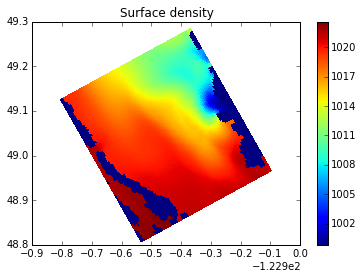

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.pcolormesh(lons, lats, rho[0,0,:,:])
plt.colorbar()
plt.title('Surface density')

In [8]:
from nowcast import research_VENUS
from nowcast import figures

Look up points for Central and East.

In [9]:
SITES=research_VENUS.SITES['VENUS']
jps = {}; ips ={}

name = 'Central'
[j, i] = figures.find_model_point(SITES[name]['lon'], SITES[name]['lat'], lons, lats, 
                                    tol_lon=0.005, tol_lat=0.002)
jps[name]=j[0]
ips[name]=i[0]

name = 'East'
[j, i] = figures.find_model_point(SITES[name]['lon'], SITES[name]['lat'], lons, lats, 
                                    tol_lon=0.005, tol_lat=0.001)
jps[name]=j[0]
ips[name]=i[0]

Quick look at density and n2

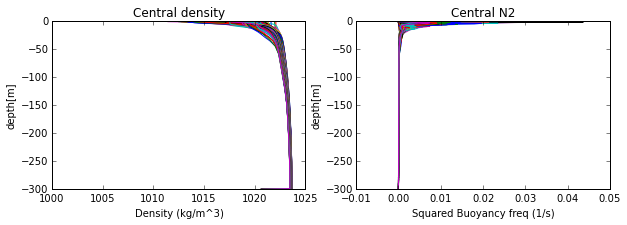

In [10]:
name = 'Central'
fig,axs = plt.subplots(1,2,figsize=(10,3))
for t in np.arange(rho.shape[0]):
    axs[0].plot( rho[t,:,jps[name],ips[name]], -depths[:,jps[name],ips[name]],)
    axs[1].plot(n2[t,:,jps[name],ips[name]], -depths[:,jps[name],ips[name]],)
ax=axs[0]
ax.set_title('{} density'.format(name))
ax.set_xlim([1000,1025])
ax.set_ylim([-300, 0])
ax.set_xlabel('Density (kg/m^3)')
ax.set_ylabel('depth[m]')
ax=axs[1]
ax.set_title('{} N2'.format(name))
ax.set_xlim([-.01, 0.05])
ax.set_ylim([ -300, 0])
ax.set_xlabel('Squared Buoyancy freq (1/s)')
ax.set_ylabel('depth[m]')

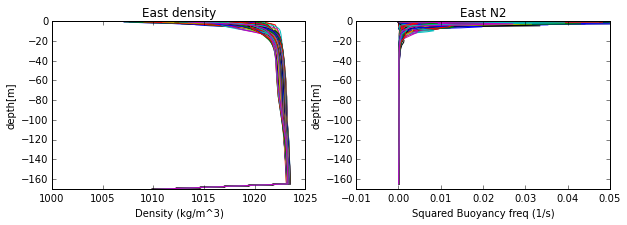

In [11]:
fig,axs = plt.subplots(1,2,figsize=(10,3))
name='East'
for t in np.arange(rho.shape[0]):
    axs[0].plot( rho[t,:,jps[name],ips[name]], -depths[:,jps[name],ips[name]],)
    axs[1].plot(n2[t,:,jps[name],ips[name]], -depths[:,jps[name],ips[name]],)
ax=axs[0]
ax.set_title('{} density'.format(name))
ax.set_xlim([1000,1025])
ax.set_ylim([-170, 0])
ax.set_xlabel('Density (kg/m^3)')
ax.set_ylabel('depth[m]')
ax=axs[1]
ax.set_title('{} N2'.format(name))
ax.set_xlim([-.01, 0.05])
ax.set_ylim([ -170, 0])
ax.set_xlabel('Squared Buoyancy freq (1/s)')
ax.set_ylabel('depth[m]')

There are more sophisticated ways of doing this, but I will use a range of upper layer depths.


## Parameters for wave calculations

In [12]:
H = {'Central': 280, 'East': 150}

M2_freq = 2*np.pi/(12.4206*3600)
g = 9.80665
f = 2*1/(24*3600)*np.sin(np.deg2rad(49)) #coriolis frequency

### Linear long wave speed
$c_0 = \sqrt{g\frac{\rho_2 - \rho_1}{\rho_2}h_1}$

In [13]:
def calculate_wave_speeds(dep_surf,name, jps, ips, H):
    #calculate straficiation params
    deps = depths[:,jps[name],ips[name]]
    rho2 = np.mean(rho[:,np.where(np.logical_and(deps>dep_surf, deps<H[name])),jps[name], ips[name]])
    rho1 = np.mean(rho[:,np.where(deps<dep_surf), jps[name], ips[name]])

    #calcilate wave speed and wave length
    co = np.sqrt( g*(rho2-rho1)/rho2*dep_surf)
    k = M2_freq/co
    lam = 2*np.pi/(k)/1000 
    
    return co, lam

In [14]:
surfaces = np.arange(3,22,3)
cos={'Central': [], 'East': []}
lams={'Central': [], 'East': []}
for surf in surfaces:
    for name in['Central', 'East']:
        co, lam = calculate_wave_speeds(surf, name, jps, ips, H)
        cos[name].append(co)
        lams[name].append(lam)

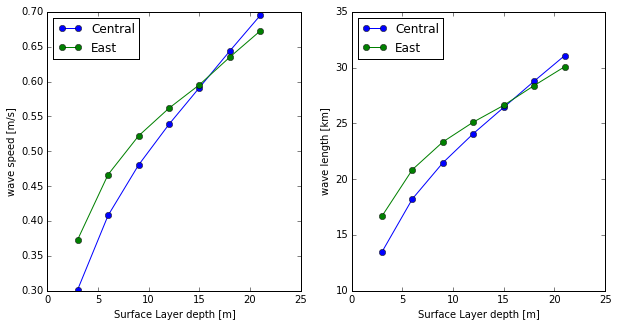

In [15]:
fig, axs=plt.subplots(1,2,figsize=(10,5))
#c0
ax=axs[0]
for name in ['Central', 'East']:
    ax.plot(surfaces, cos[name], '-o', label= name)
    ax.set_xlabel('Surface Layer depth [m]')
    ax.set_ylabel('wave speed [m/s]')
    ax.legend(loc=0)
#lam
ax=axs[1]
for name in ['Central', 'East']:
    ax.plot(surfaces, lams[name], '-o', label= name)
    ax.set_xlabel('Surface Layer depth [m]')
    ax.set_ylabel('wave length [km]')
    ax.legend(loc=0)

### Constant N
$slope = \sqrt{\frac{\omega^2 - f^2}{N^2-\omega^2}}$.

In [16]:
def calculate_beam_slope(dep_surf, name, jps, ips, H):
    deps = depths[:,jps[name],ips[name]]
    n2_deep = np.mean(n2[:,np.where(np.logical_and(deps>dep_surf, deps<H[name])),jps[name], ips[name]])
    slope = np.sqrt((M2_freq**2 - f**2)/(n2_deep - M2_freq**2))
    return slope

In [17]:
slopes = {'Central':[], 'East': []}
for dep_surf in surfaces:
    for name in ['East','Central']:
        s= calculate_beam_slope(dep_surf, name, jps, ips, H)
        slopes[name].append(s)

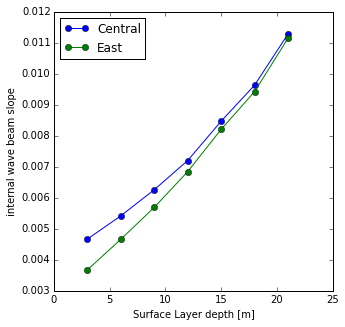

In [18]:
fig, ax=plt.subplots(1,1,figsize=(5,5))
for name in ['Central', 'East']:
    ax.plot(surfaces, slopes[name], '-o',label=name)
    ax.set_xlabel('Surface Layer depth [m]')
    ax.set_ylabel('internal wave beam slope')
ax.legend(loc=0)

Check in model? My estimate is (based on eyeballs of beam rise and run):

In [19]:
dx =(100-70)*500
dz = 130
dz/dx

0.008666666666666666